In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [3]:
df = pd.read_csv('../Sleep_health_and_lifestyle_dataset.csv')
df.head(10)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
9,10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN


### 1. Добавление нового аттрибута:

In [4]:
def calculate_work_life_balance(row):
    occupation = df[df['Occupation'] == row['Occupation']]
    avg_sleep = occupation['Sleep Duration'].mean()
    avg_activity = occupation['Physical Activity Level'].mean()

    sleep_ratio = row['Sleep Duration'] / avg_sleep
    activity_ratio = row['Physical Activity Level'] / avg_activity
    
    score = (sleep_ratio * activity_ratio) ** 0.5 * 100
    return score

df['Work_life_balance'] = df.apply(calculate_work_life_balance, axis=1)
print(df[['Person ID', 'Occupation', 'Sleep Duration', 'Physical Activity Level', 'Work_life_balance']].head(10))

   Person ID            Occupation  Sleep Duration  Physical Activity Level  \
0          1     Software Engineer             6.1                       42   
1          2                Doctor             6.2                       60   
2          3                Doctor             6.2                       60   
3          4  Sales Representative             5.9                       30   
4          5  Sales Representative             5.9                       30   
5          6     Software Engineer             5.9                       30   
6          7               Teacher             6.3                       40   
7          8                Doctor             7.8                       75   
8          9                Doctor             7.8                       75   
9         10                Doctor             7.8                       75   

   Work_life_balance  
0          88.923604  
1          98.191708  
2          98.191708  
3         100.000000  
4         100.0

### Анализ результата: Work_life_balance  
*   **> 100:** Хороший баланс
*   **100:** Средний результат
*   **< 100:** Плохой баланс

### Типы данных: 

In [33]:
numeric_columns = ['Age',
                   'Sleep Duration', 
                   'Quality of Sleep',
                   'Physical Activity Level',
                   'Stress Level',
                   'Heart Rate',
                   'Daily Steps'
                  ]

categorical_columns = ['Gender',
                       'Occupation', 
                       'BMI Category',
                       'Sleep Disorder',
                       'Blood Pressure'
                      ]

### 2. Отчистка датасета:

In [34]:
def remove_multiple_outliers(df, columns, threshold=1):
    outlier_cnt = pd.Series(0, index=df.index)

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        outlier_cnt += ((df[col] < lower) | (df[col] > upper)).astype(int)

    rows_to_remove = outlier_cnt >= threshold
    df_clean = df[~rows_to_remove].copy()
    return df_clean, rows_to_remove.sum()


def remove_illogical_data(df):

    df_temp = df.copy()
    df_temp[['Systolic_BP', 'Diastolic_BP']] = df_temp['Blood Pressure'].str.split('/', expand=True).astype(int)
    
    illogical_mask = (
         # Некорректное давление
        (df_temp['Systolic_BP'] <= df_temp['Diastolic_BP']) |
        (df_temp['Systolic_BP'] < 70) | (df_temp['Systolic_BP'] > 250) |
        (df_temp['Diastolic_BP'] < 40) | (df_temp['Diastolic_BP'] > 150) |

        # Некорректный пульс
        (df['Heart Rate'] < 40) | (df['Heart Rate'] > 200) |
        
        # Некорректное количество шагов
        (df['Daily Steps'] > 50000) |

        # Небольшая продолжительность сна и низкий уровень стресса
        (df['Sleep Duration'] < 6.5) & (df['Stress Level'] < 7) |

        # Высокая физическая активность, но низкое количество шагов
        ((df['Physical Activity Level'] > 70) & (df['Daily Steps'] < 3000)) |

        # Высокая активность но низкий пульс в покое (противоречие)
        ((df['Physical Activity Level'] > 80) & (df['Heart Rate'] < 50))
    )

    df_clean = df[~illogical_mask].copy()
    return df_clean, illogical_mask.sum()


def analyze_distributions(df):
    round_cnt = pd.Series(False, index=df.index)
    special_columns = ['Sleep Duration', 
                       'Physical Activity Level',
                       'Heart Rate'
                      ]
    
    for col in special_columns:
        round_cnt = round_cnt | (df[col] % 5 == 0)
        
    return round_cnt.sum()


def clean_dataset(df):
    total_cnt = 0
    changed_df = df.copy()

    duplicates = [col for col in changed_df.columns if col != 'Person ID']
    changed_df = changed_df.drop_duplicates(subset=duplicates)
    dubl_cnt = len(df) - len(changed_df)
    print(f'1. Количество дубликатов: {dubl_cnt}')
    total_cnt += dubl_cnt
    
    changed_df, rows_cnt = remove_multiple_outliers(changed_df, numeric_columns, threshold=1)
    print(f'2. Количество строк с выбросами: {rows_cnt}')
    total_cnt += rows_cnt
    
    # Пропуски присутствуют только в столбце 'Sleep Disorder',
    # которые логически означают отсутвие расстройства сна
    changed_df['Sleep Disorder'] = changed_df['Sleep Disorder'].fillna('None')

    # Кривые данные
    changed_df, issues_cnt = remove_illogical_data(changed_df)
    print(f'3. Логические проблемы (количество записей): {issues_cnt}')
    total_cnt += issues_cnt

    round_cnt = analyze_distributions(changed_df)
    print(f'4. Количество строк с идеальными данными: {round_cnt}')

    return changed_df, total_cnt

new_df, total_cnt = clean_dataset(df)
print(f'Исходное количество строк: {len(df)}')
print(f'Удалено строк: {total_cnt}')
print(new_df)

1. Количество дубликатов: 242
2. Количество строк с выбросами: 5
3. Логические проблемы (количество записей): 3
4. Количество строк с идеальными данными: 122
Исходное количество строк: 374
Удалено строк: 250
     Person ID  Gender  Age Occupation  Sleep Duration  Quality of Sleep  \
1            2    Male   28     Doctor             6.2                 6   
6            7    Male   29    Teacher             6.3                 6   
7            8    Male   29     Doctor             7.8                 7   
10          11    Male   29     Doctor             6.1                 6   
13          14    Male   29     Doctor             6.0                 6   
..         ...     ...  ...        ...             ...               ...   
358        359  Female   59      Nurse             8.0                 9   
359        360  Female   59      Nurse             8.1                 9   
360        361  Female   59      Nurse             8.2                 9   
364        365  Female   59     

### 3. Построение графиков зависимости и описание кластеров (групп): 

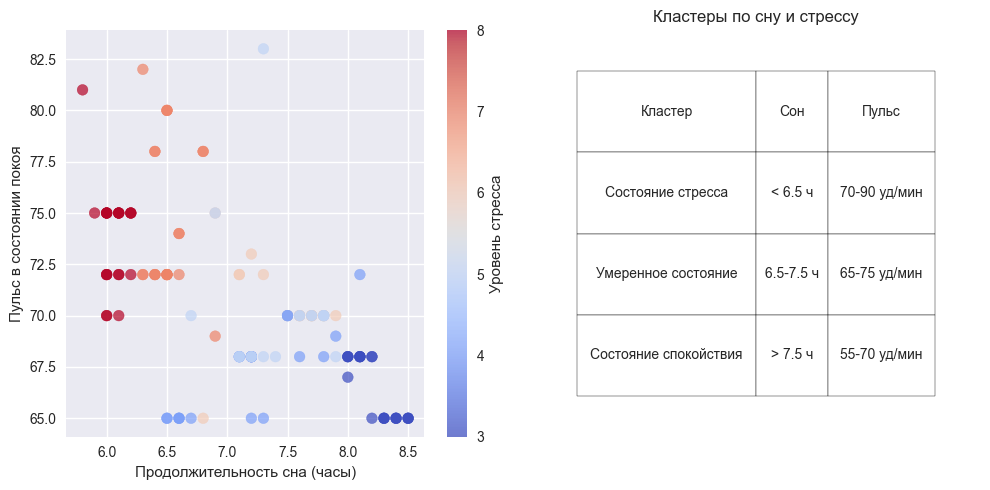

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

scatter = ax1.scatter(new_df['Sleep Duration'], new_df['Heart Rate'], c=new_df['Stress Level'], cmap='coolwarm', alpha=0.7, s=60)
ax1.set_xlabel('Продолжительность сна (часы)')
ax1.set_ylabel('Пульс в состоянии покоя')
plt.colorbar(scatter, ax=ax1, label='Уровень стресса')  

ax2.axis('off')
cluster_data = {
    'Кластер': ['Состояние стресса', 'Умеренное состояние', 'Состояние спокойствия'],
    'Сон': ['< 6.5 ч', '6.5-7.5 ч', '> 7.5 ч'],
    'Пульс': ['70-90 уд/мин', '65-75 уд/мин', '55-70 уд/мин']
}

cluster_df = pd.DataFrame(cluster_data)
ax2.set_title('Кластеры по сну и стрессу')
table = ax2.table(cellText=cluster_df.values,
                colLabels=cluster_df.columns,
                cellLoc='center', 
                loc='center',
                bbox=[0.1, 0.1, 0.8, 0.8], 
                colWidths=[0.5, 0.2, 0.3])  

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

plt.tight_layout()
plt.show()

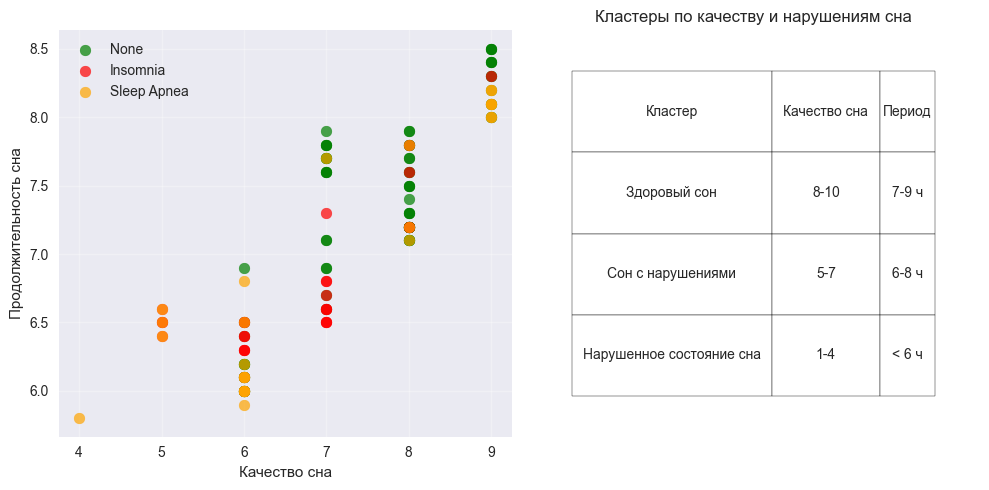

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sleep_colors = {'None': 'green', 'Insomnia': 'red', 'Sleep Apnea': 'orange'}
for disorder, color in sleep_colors.items():
    mask = new_df['Sleep Disorder'] == disorder
    ax1.scatter(new_df[mask]['Quality of Sleep'], new_df[mask]['Sleep Duration'], c=color, label=disorder, alpha=0.7, s=60)
    
ax1.set_xlabel('Качество сна')
ax1.set_ylabel('Продолжительность сна')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.axis('off')
cluster_data = {
    'Кластер': ['Здоровый сон', 'Сон с нарушениями', 'Нарушенное состояние сна'],
    'Качество сна': ['8-10', '5-7', '1-4'],
    'Период': ['7-9 ч', '6-8 ч', '< 6 ч']
}

cluster_df = pd.DataFrame(cluster_data)
ax2.set_title('Кластеры по качеству и нарушениям сна')
table = ax2.table(cellText=cluster_df.values,
                colLabels=cluster_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0.1, 0.1, 0.8, 0.8], 
                colWidths=[0.55, 0.3, 0.15])

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)  

plt.tight_layout()
plt.show()

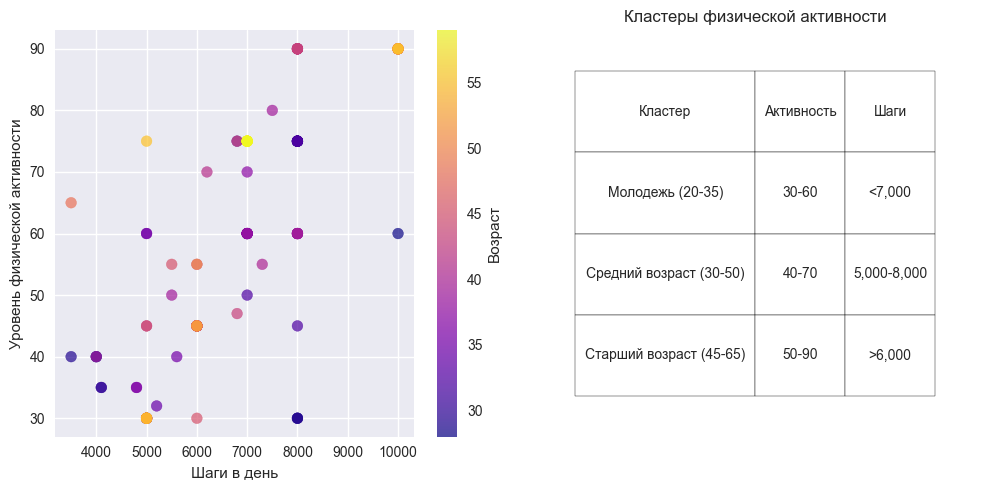

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

scatter = ax1.scatter(new_df['Daily Steps'], new_df['Physical Activity Level'], c=new_df['Age'], cmap='plasma', alpha=0.7, s=60)
ax1.set_xlabel('Шаги в день')
ax1.set_ylabel('Уровень физической активности')
plt.colorbar(scatter, ax=ax1, label='Возраст')

ax2.axis('off')
cluster_data = {
    'Кластер': ['Молодежь (20-35)', 'Средний возраст (30-50)', 'Старший возраст (45-65)'],
    'Активность': ['30-60', '40-70', '50-90'], 
    'Шаги': ['<7,000', '5,000-8,000', '>6,000']
}

cluster_df = pd.DataFrame(cluster_data)
ax2.set_title('Кластеры физической активности')
table = ax2.table(cellText=cluster_df.values,
                colLabels=cluster_df.columns,
                cellLoc='center', 
                loc='center',
                bbox=[0.1, 0.1, 0.8, 0.8], 
                colWidths=[0.6, 0.3, 0.3])  

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

### 4. Метод KMeans: 

In [41]:
data = new_df.copy()

data = data.drop('Person ID', axis=1)
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

data[['Systolic_BP', 'Diastolic_BP']] = data['Blood Pressure'].str.split('/', expand=True).astype(int)
data = data.drop('Blood Pressure', axis=1)

bmi_mapping = {'Underweight': 0, 'Normal': 1, 'Normal Weight': 1, 'Overweight': 2, 'Obese': 3}
data['BMI_Category_Encoded'] = data['BMI Category'].map(bmi_mapping)
data = data.drop('BMI Category', axis=1)

data['Has_Sleep_Disorder'] = (data['Sleep Disorder'] != 'None').astype(int)
data = data.drop('Sleep Disorder', axis=1)
data = data.drop('Occupation', axis=1)
data = data.drop('Work_life_balance', axis=1)

print(data.head(10))
print(data.info())

    Gender  Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
1        0   28             6.2                 6                       60   
6        0   29             6.3                 6                       40   
7        0   29             7.8                 7                       75   
10       0   29             6.1                 6                       30   
13       0   29             6.0                 6                       30   
16       1   29             6.5                 5                       40   
17       0   29             6.0                 6                       30   
18       1   29             6.5                 5                       40   
19       0   30             7.6                 7                       75   
20       0   30             7.7                 7                       75   

    Stress Level  Heart Rate  Daily Steps  Systolic_BP  Diastolic_BP  \
1              8          75        10000          125            80 

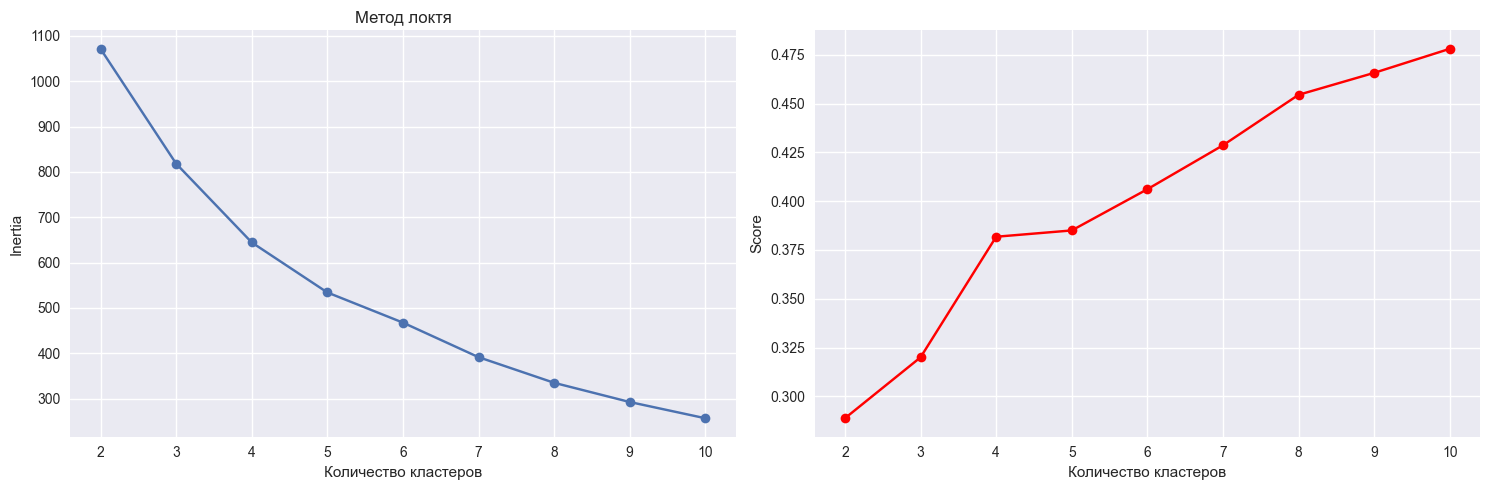

In [46]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

inertia = [] 
s_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

    if i > 1:
        curr_score = silhouette_score(data_scaled, kmeans.labels_)
        s_scores.append(curr_score)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), s_scores, marker='o', color='red')
plt.xlabel('Количество кластеров')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [82]:
clusters_cnt = 3
kmeans = KMeans(n_clusters=clusters_cnt, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

new_df['Cluster'] = clusters
data['Cluster'] = clusters

print("Распределение по кластерам:")
print(new_df['Cluster'].value_counts())

Распределение по кластерам:
Cluster
0    59
2    34
1    31
Name: count, dtype: int64


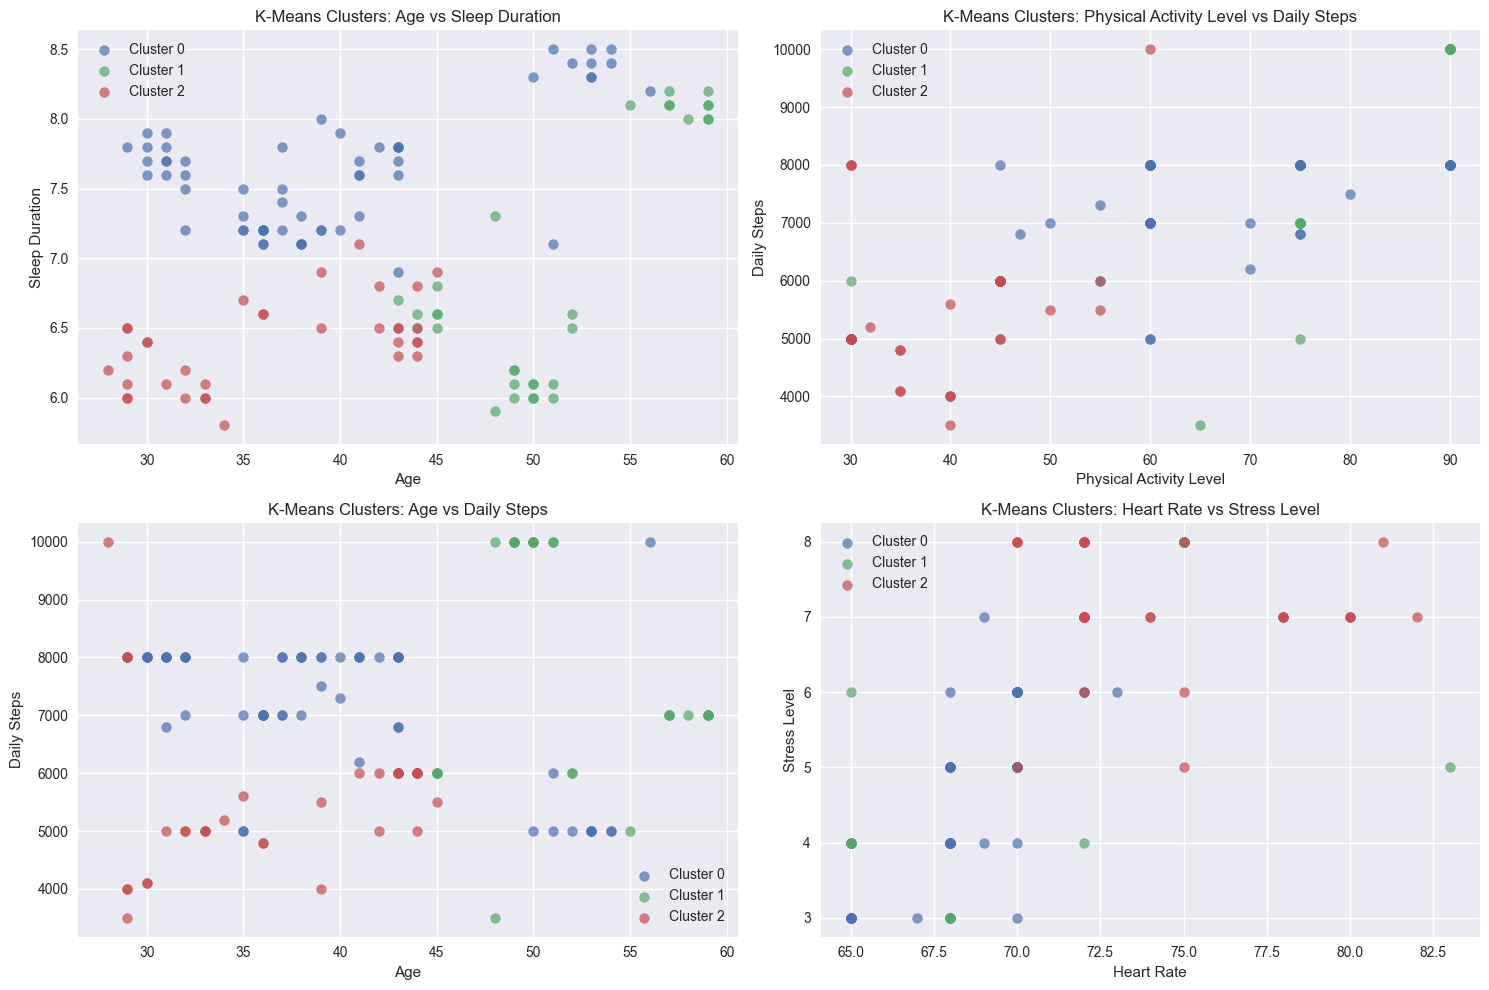

In [91]:
pairs = [
    ('Age', 'Sleep Duration'),
    ('Physical Activity Level', 'Daily Steps'), 
    ('Age', 'Daily Steps'),
    ('Heart Rate', 'Stress Level')
]

plt.figure(figsize=(15, 10))
for i, (x_feat, y_feat) in enumerate(pairs, 1):
    plt.subplot(2, 2, i)
    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]
        plt.scatter(cluster_data[x_feat], cluster_data[y_feat], label=f'Cluster {cluster}', alpha=0.7, s=50)
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.legend()
    plt.title(f'K-Means Clusters: {x_feat} vs {y_feat}')

plt.tight_layout()
plt.show()

In [92]:
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    
    print(f"\nКластер {cluster} ({len(cluster_data)} человек, {len(cluster_data)/len(data)*100:.1f}%) ---")
    print("Характеристики:")
    print(f"- Возраст: {cluster_data['Age'].mean():.1f} лет")
    print(f"- Продолжительность сна: {cluster_data['Sleep Duration'].mean():.1f} часов")
    print(f"- Качество сна: {cluster_data['Quality of Sleep'].mean():.1f}/10")
    print(f"- Уровень стресса: {cluster_data['Stress Level'].mean():.1f}/10")
    print(f"- Физ. активность: {cluster_data['Physical Activity Level'].mean():.1f}")
    print(f"- Шаги в день: {cluster_data['Daily Steps'].mean():.0f}")
    print(f"- Пульс: {cluster_data['Heart Rate'].mean():.1f} уд/мин")
    print(f"- Давление: {cluster_data['Systolic_BP'].mean():.0f}/{cluster_data['Diastolic_BP'].mean():.0f}")
    print(f"- BMI категория: {cluster_data['BMI_Category_Encoded'].mean():.2f}")
    print(f"- Наличие расстройств сна: {cluster_data['Has_Sleep_Disorder'].mean()*100:.1f}%")
    
    gender_ratio = cluster_data['Gender'].value_counts(normalize=True)
    print(f"- Мужчины: {gender_ratio.get(0, 0)*100:.1f}%")
    print(f"- Женщины: {gender_ratio.get(1, 0)*100:.1f}%")


Кластер 0 (59 человек, 47.6%) ---
Характеристики:
- Возраст: 39.5 лет
- Продолжительность сна: 7.6 часов
- Качество сна: 7.9/10
- Уровень стресса: 4.6/10
- Физ. активность: 63.7
- Шаги в день: 7142
- Пульс: 68.4 уд/мин
- Давление: 123/80
- BMI категория: 1.02
- Наличие расстройств сна: 15.3%
- Мужчины: 59.3%
- Женщины: 40.7%

Кластер 1 (31 человек, 25.0%) ---
Характеристики:
- Возраст: 51.2 лет
- Продолжительность сна: 6.9 часов
- Качество сна: 7.3/10
- Уровень стресса: 5.4/10
- Физ. активность: 70.8
- Шаги в день: 7597
- Пульс: 70.7 уд/мин
- Давление: 138/93
- BMI категория: 2.03
- Наличие расстройств сна: 80.6%
- Мужчины: 3.2%
- Женщины: 96.8%

Кластер 2 (34 человек, 27.4%) ---
Характеристики:
- Возраст: 36.4 лет
- Продолжительность сна: 6.4 часов
- Качество сна: 5.9/10
- Уровень стресса: 7.1/10
- Физ. активность: 39.9
- Шаги в день: 5562
- Пульс: 74.1 уд/мин
- Давление: 128/84
- BMI категория: 1.59
- Наличие расстройств сна: 58.8%
- Мужчины: 76.5%
- Женщины: 23.5%


### 5. Выводы: 
* **Добавление нового атрибута**:
    * Добавлен атрибут 'Work_life_balance' на основе: 'Occupation', 'Sleep Duration', 'Physical Activity Level' для того, чтобы проанализировать, как профессия влияет общее качетво жизни (активность, сон)
* **Подготовка данных**:
    * На основе исходного датасета был создан новый
    * Удалены дубликаты, выбросы, пропуски, записи с логическими проблемами
    * Проанализированы идеальные данные (круглые числа)
* **Визуальный анализ**:
    * Построены 3 графика
    * 1 график: анализ атрибутов 'Sleep Duration', 'Heart Rate', 'Stress Level' с выделением кластеров: Состояние стресса, Умеренное состояние, Состояние спокойствия
    * 2 график: анализ атрибутов 'Sleep Disorder', 'Quality of Sleep', 'Sleep Duration' с выделением кластеров: Здоровый сон, Сон с нарушениями, Нарушенное состояние сна
    * 3 график: анализ атрибутов 'Age', 'Daily Steps', 'Physical Activity Level' с выделением кластеров по возрасту
* **Метод KMeans**:
    * Хотя формальные метрики указывали на k=4 (метод локтя), содержательный анализ показал, что k=3 дает более сбалансированное и интерпретируемые результаты для сегментации
    * Кластер 0: здоровые активные люди среднего возраста
    * Кластер 1: женщины пожилого возраста с расстройством сна и гипертонией
    * Кластер 2: мужчины (больший %) с высоким уровнем стресса и небольшой продолжительностью сна